### Adicionadas bibliotecas necessárias 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
import pickle

### Abrir o arquivo csv com os serviços classificados pelos pesquisadores 

In [2]:
# Open the file with the data
df = pd.read_csv("servicos_atualizado.csv")
df.dropna(inplace=True)
df.head()

,id,tags,taken,latitude,longitude,accuracy,secs
0,128886679,baseball hat | city | city view | cliff | hill...,14/4/2006 09:30,0,0,0,"1,2,4,6,10"
1,137155357,dam | hill | hillside | lagoon | lake | mounta...,29/4/2006 17:19,0,0,0,"1,2,11"
2,160198029,army | camouflage | dirt field | field | gun |...,1/1/2004 00:00,0,0,0,"1,9"
3,241150943,building | city | city skyline | city view | f...,11/9/2006 23:26,"-19,950054","-43,908405",140,2
4,241150968,city | hill | hillside | mound | mountain | peak,11/9/2006 23:26,"-19,950054","-43,908405",140,"1,2"


### Para cada tag que foi identificada em todas as imagens a adicionamos em uma lista de tags, que será usada para representar binariamente se ela está presente ou não em cada serviço

In [3]:
# Create a bag of words and a matrix representing if that word is in the text
bag_of_words = set()
for row in df["tags"]:
    for word in row.replace(" ", "").split("|"):
        bag_of_words.add(word)

bag_of_words = list(bag_of_words)
bag_of_words.sort()
len(bag_of_words)

368

### Listamos todos os serviços

In [4]:
# Create a bag of words to represent the classes
classes = set()
for row in df["secs"]:
    for classe in row.replace(" ", "").split(","):
        classes.add(int(classe))

classes = list(classes)
classes.sort()
classes = [str(classe) for classe in classes]
classes

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

In [5]:
# Create a matrix where each row is a text and each column is a word
matrix = []
for row in df["tags"]:
    matrix.append([1 if word in row.replace(" ", "").split("|") else 0 for word in bag_of_words])

matrix = np.array(matrix)

In [6]:
matrix.shape

(249, 368)

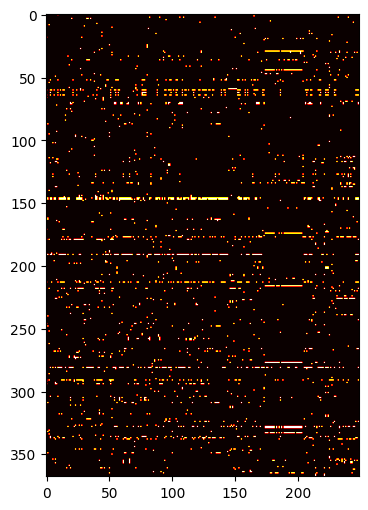

In [7]:
# Vizualize the matrix as a image
import matplotlib.pyplot as plt
# Size of the image 10x10
plt.figure(figsize=(6,6))
plt.imshow(matrix.T, cmap='hot')
plt.show()

In [8]:
servicos = []
for row in df["secs"]:
    servicos.append([1 if classe in row.replace(" ", "").split(",") else 0 for classe in classes])

servicos = np.array(servicos)
servicos.shape
servicos

array([[1, 1, 0, ..., 1, 0, 0],
       [1, 1, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [9]:
soma = np.zeros(len(servicos[0]))
for i in range(len(servicos)):
    soma += servicos[i]

soma

array([115.,  78.,  63.,  19.,  15.,  17.,  12.,  10.,  10.,   9.,  18.,
        10.])

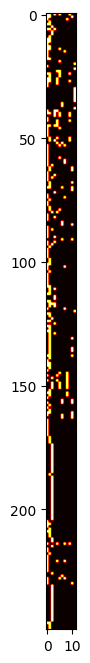

In [10]:
# Size of the image 10x10
plt.figure(figsize=(8,8))
plt.imshow(servicos, cmap='hot')
plt.show()

In [36]:
# Split the data in train and test
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier

X_train, X_test, y_train, y_test = train_test_split(matrix, servicos, test_size=0.33)
randon_forest = MultiOutputClassifier(RandomForestClassifier(n_estimators=100)).fit(X_train,y_train)

# Predict the test data
y_pred = randon_forest.predict(X_test)

In [37]:
soma = np.zeros(len(y_train[0]))
for i in range(len(y_train)):
    soma += y_train[i]

soma

array([77., 56., 41., 16., 10., 12.,  9.,  9.,  6.,  7., 11.,  5.])

In [38]:
soma = np.zeros(len(y_test[0]))
for i in range(len(y_test)):
    soma += y_test[i]

soma

array([38., 22., 22.,  3.,  5.,  5.,  3.,  1.,  4.,  2.,  7.,  5.])

In [39]:
# Calculate the accuracy
from sklearn.metrics import accuracy_score
for i in range(0, len(classes)):
    print(classes[i], accuracy_score(y_test[:,i], y_pred[:,i]))

1 0.7590361445783133
2 0.963855421686747
3 0.9759036144578314
4 0.9759036144578314
5 0.9397590361445783
6 0.927710843373494
7 0.9759036144578314
8 0.9879518072289156
9 0.9518072289156626
10 0.9759036144578314
11 0.963855421686747
12 0.963855421686747


In [41]:
# Save the models
pickle.dump(randon_forest, open("randon_forest.pkl", "wb"))
pickle.dump(bag_of_words, open("bag_of_words.pkl", "wb"))
pickle.dump(classes, open("classes.pkl", "wb"))

In [47]:
for i in range(0, len(classes)):
    # Feature importance in the model
    importances = randon_forest.estimators_[i].feature_importances_
    std = np.std([tree.feature_importances_ for tree in randon_forest.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    print("%s) " % classes[i], end=" ")
    # Print the feature ranking
    for f in range(0, 50):
        print("%d. %s (%f) " % (f + 1, bag_of_words[indices[f]], importances[indices[f]]), end="\t")
    print("")

1)  1. mountain (0.070954) 	2. sky (0.037869) 	3. hill (0.036401) 	4. hillside (0.035503) 	5. building (0.017412) 	6. cloud (0.017163) 	7. peak (0.016404) 	8. city (0.015587) 	9. bird (0.015469) 	10. cityview (0.014665) 	11. cross (0.014297) 	12. suburb (0.014062) 	13. stand (0.013425) 	14. mountainview (0.012839) 	15. urban (0.012516) 	16. scenery (0.012411) 	17. cityskyline (0.011644) 	18. cloudy (0.010882) 	19. tree (0.010716) 	20. valley (0.010369) 	21. lush (0.010345) 	22. surround (0.010138) 	23. treebranch (0.010119) 	24. limb (0.009881) 	25. twig (0.009871) 	26. plant (0.009817) 	27. blanket (0.009179) 	28. plaza (0.009132) 	29. stone (0.009114) 	30. town (0.009093) 	31. water (0.008910) 	32. rockformation (0.008834) 	33. branch (0.008532) 	34. build (0.008391) 	35. man (0.008242) 	36. photo (0.008003) 	37. sea (0.007390) 	38. mountainpath (0.007009) 	39. sit (0.006863) 	40. lake (0.006861) 	41. streetsign (0.006663) 	42. boulder (0.006643) 	43. loom (0.006580) 	44. person (0.0

In [48]:
#  Columns =["id", "model_identified_tags"])
serra_null_gps = pd.read_csv("serra_tags_null_gps.csv", sep=";")
serra_null_gps = serra_null_gps[["id", "model_identified_tags"]]
serra_null_gps

,id,model_identified_tags
0,52904733325,barrel | basement | beam | ceiling | container...
1,9241659630,balustrade | city | city view | hill | hillsid...
2,15187099604,bird | branch | brown | log | peak | perch | p...
3,2123658330,blanket | cloud | cloudy | green | hill | hill...
4,52904796013,bicycle | bicycle helmet | biker | dirt track ...
...,...,...
3082,9860799366,daisy | flower | grass | grow | plant | stem |...
3083,4793139481,backdrop | building | city | city skyline | ci...
3084,51131866624,blue | bud | floor | flower | grass | grow | p...
3085,15787763770,bloom | flower | grow | pink | plant | tree


In [49]:
# Create a matrix where each row is a text and each column is a word
null_tags = []
for row in serra_null_gps["model_identified_tags"]:
    null_tags.append([1 if word in row.replace(" ", "").split("|") else 0 for word in bag_of_words])

null_tags = np.array(null_tags)
results = randon_forest.predict(null_tags)

In [50]:
# Turn the results into a dataframe and join with the original dataframe
results_df = pd.DataFrame(results, columns=classes)
results_df = pd.concat([serra_null_gps, results_df], axis=1)
results_df

,id,model_identified_tags,1,2,3,4,5,6,7,8,9,10,11,12
0,52904733325,barrel | basement | beam | ceiling | container...,0,0,0,0,0,0,0,0,0,0,0,0
1,9241659630,balustrade | city | city view | hill | hillsid...,1,1,0,0,0,0,0,0,0,0,0,0
2,15187099604,bird | branch | brown | log | peak | perch | p...,0,0,1,0,0,0,0,0,0,0,0,0
3,2123658330,blanket | cloud | cloudy | green | hill | hill...,1,0,0,0,0,0,0,0,0,0,0,0
4,52904796013,bicycle | bicycle helmet | biker | dirt track ...,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3082,9860799366,daisy | flower | grass | grow | plant | stem |...,0,0,1,0,0,0,0,0,0,0,0,0
3083,4793139481,backdrop | building | city | city skyline | ci...,1,0,0,0,0,0,0,0,0,0,0,0
3084,51131866624,blue | bud | floor | flower | grass | grow | p...,0,0,1,0,0,0,0,0,0,0,0,0
3085,15787763770,bloom | flower | grow | pink | plant | tree,0,0,1,0,0,0,0,0,0,0,0,0


In [56]:
# Predicted classes 
results_df["predicted_classes"] = results_df.apply(lambda row: ",".join([classes[i] for i in range(0, len(classes)) if row[classes[i]] == 1]), axis=1)
results_df

,id,model_identified_tags,1,2,3,4,5,6,7,8,9,10,11,12,predicted_classes
0,52904733325,barrel | basement | beam | ceiling | container...,0,0,0,0,0,0,0,0,0,0,0,0,
1,9241659630,balustrade | city | city view | hill | hillsid...,1,1,0,0,0,0,0,0,0,0,0,0,"1,2"
2,15187099604,bird | branch | brown | log | peak | perch | p...,0,0,1,0,0,0,0,0,0,0,0,0,3
3,2123658330,blanket | cloud | cloudy | green | hill | hill...,1,0,0,0,0,0,0,0,0,0,0,0,1
4,52904796013,bicycle | bicycle helmet | biker | dirt track ...,0,0,0,0,0,0,0,0,0,0,0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3082,9860799366,daisy | flower | grass | grow | plant | stem |...,0,0,1,0,0,0,0,0,0,0,0,0,3
3083,4793139481,backdrop | building | city | city skyline | ci...,1,0,0,0,0,0,0,0,0,0,0,0,1
3084,51131866624,blue | bud | floor | flower | grass | grow | p...,0,0,1,0,0,0,0,0,0,0,0,0,3
3085,15787763770,bloom | flower | grow | pink | plant | tree,0,0,1,0,0,0,0,0,0,0,0,0,3


In [59]:
results_df.to_csv("results_predicted.csv", sep=";", index=False)

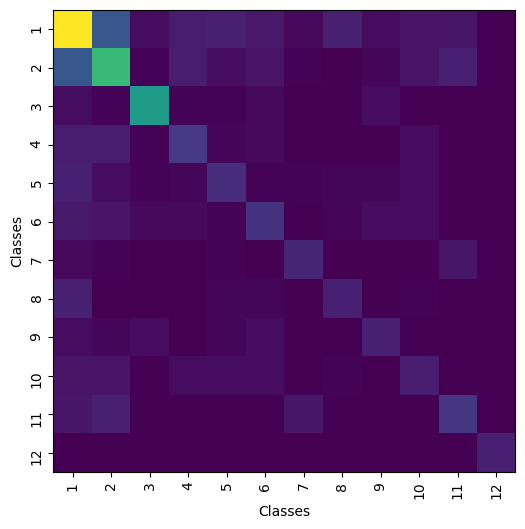

In [58]:
# For each row in servicos, count the number of interactions between the classes
interacao = np.zeros((servicos.shape[1], servicos.shape[1]))
for row in servicos:
    for i in range(len(row)):
        for j in range(len(row)):
            if row[i] == 1 and row[j] == 1:
                interacao[i][j] += 1

plt.figure(figsize=(6,6))
plt.xlabel("Classes")
plt.xticks(range(len(classes)), classes, rotation=90)
plt.ylabel("Classes")
plt.yticks(range(len(classes)), classes, rotation=90)
plt.imshow(interacao, cmap='viridis')
plt.show()

In [25]:
# Get diagonal from interacao
diagonal = np.array([interacao[i][i] for i in range(len(interacao))])
diagonal

array([115.,  78.,  63.,  19.,  15.,  17.,  12.,  10.,  10.,   9.,  18.,
        10.])

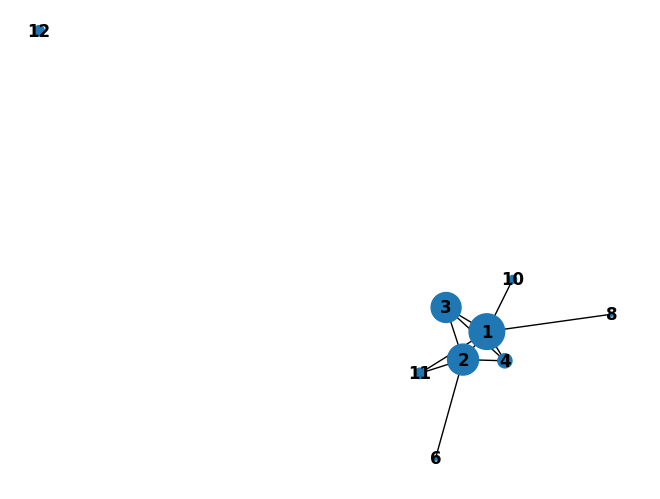

In [40]:
import networkx as nx

np.fill_diagonal(interacao, 0)
G = nx.from_numpy_array(interacao)

# Relable the nodes to the classes names
mapping = {i:classes[i] for i in range(len(classes))}
G = nx.relabel_nodes(G, mapping)
nx.draw(G, with_labels=True, font_weight='bold', node_size=diagonal*8)

